In [1]:
import sys
import nltk
import sklearn
import pandas
import numpy
import matplotlib
import seaborn as sns
from IPython.display import Image
from IPython.core.display import SVG

print('Python:',sys.version)
print('NLTK:',nltk.__version__)
print('Scikit-learn:',sklearn.__version__)
print('Pandas:',pandas.__version__)
print('Numpy:',numpy.__version__)
print('Matplotlib:',matplotlib.__version__)

Python: 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]
NLTK: 3.6.2
Scikit-learn: 0.24.2
Pandas: 1.3.1
Numpy: 1.20.3
Matplotlib: 3.4.2


## 1- Veri Seti Yükleme

### Veri Seti Hakkında

Bu derlem, İnternet'teki araştırma kaynaklarından ücretsiz olarak toplanmıştır:

425 SMS spam mesajı koleksiyonu, Grubletext Web sitesinden manuel olarak alınmıştır. Bu, cep telefonu kullanıcılarının, çoğu alınan spam mesajını bildirmeden, SMS spam mesajları hakkında kamuya açık iddialarda bulunduğu bir Birleşik Krallık forumudur. İddialarda yer alan spam mesajlarının metninin belirlenmesi çok zor ve zaman alan bir iştir ve yüzlerce web sayfasının dikkatlice taranmasını gerektirir.
Singapur Ulusal Üniversitesi Bilgisayar Bilimleri Bölümünde araştırma için toplanan yaklaşık 10.000 meşru mesajdan oluşan bir veri seti olan NUS SMS Corpus'un (NSC) rastgele seçilmiş 3.375 SMS'lik bir alt kümesi. Mesajlar büyük ölçüde Singapurlulardan ve çoğunlukla Üniversiteye devam eden öğrencilerden geliyor. Bu mesajlar, katkılarının kamuya açık hale getirileceği konusunda bilgilendirilen gönüllülerden toplandı.

Öznitelik Bilgileri:
Koleksiyon, her satırın doğru sınıfa ve ardından ham mesaja sahip olduğu tek bir metin dosyasından oluşur.
- label: Mesajın ham ya da spam sınıfına ait olduğunu belirtir.
- message: Mesajı içerir.

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

In [3]:
df=pd.read_table("SMSSpamCollection.csv",header=None,names=["label","message"])
# veri seti yüklendi

In [4]:
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df.info()
# Veri seti ile ilgili ön bilgiler.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [6]:
df.shape
# veri setinin boyutu

(5572, 2)

In [7]:
# Gelen mesajların sınıf dağılımlarını inceleyelim.
df["label"].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

Yukarıda etiketlerini aldığımız mesaj tiplerini burada binary değer olarak tanımlayacağız. Yani "ham=0 , spam=1" şeklinde. Bu ileride bizim makine öğrenme algoritmamız için kolaylık ve daha basit şekilde sonuca gitmemize yarayacaktır. Bunu yapmanın pek çok yolu vardır. Ben burada map() fonksiyonunu kullanacağım.

In [8]:
df['labels'] = df['label'].map({'ham': 0, 'spam': 1})
df.drop(["label"],axis=1,inplace=True)
df

,message,labels
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0
...,...,...
5567,This is the 2nd time we have tried 2 contact u...,1
5568,Will ü b going to esplanade fr home?,0
5569,"Pity, * was in mood for that. So...any other s...",0
5570,The guy did some bitching but I acted like i'd...,0


In [9]:
print("Toplam ham mesaj sayısı: {}\nToplam spam mesaj sayısı: {}".
      format(df['labels'].value_counts()[0],df['labels'].value_counts()[1]))

Toplam ham mesaj sayısı: 4825
Toplam spam mesaj sayısı: 747


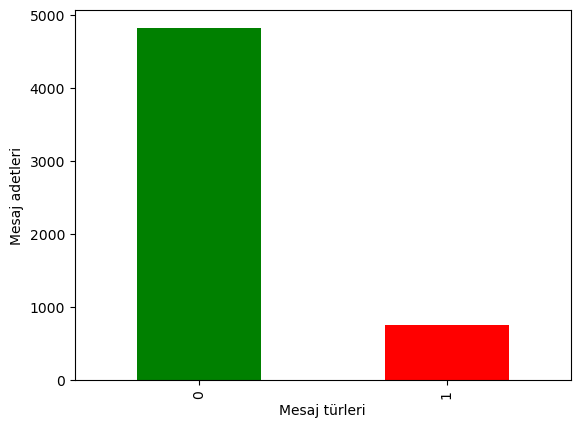

In [10]:
df['labels'].value_counts().plot.bar(color=['green','red'])
plt.xlabel('Mesaj türleri')
plt.ylabel('Mesaj adetleri')
plt.show()
# 0 ham mesajları, 1 ise spam mesajları temsil eder.

## Feature engineering(Feature Extraction) | Özellik(Değişken) Çıkarımı
Ham veri setimizdeki satır ve sutünları kullanarak bazen gerektiğinde çok işimize yaramayan verileri çıkartır veya değiştiririz. Örneğin yukarıda ham mesaj tipini '0' , spam mesaj tipini '1' olarak tanımladık. Bu örnek aslında tam olarak bu başlık altına girmesede konunun anlaşılması açısından önemi vardır.

Bu başlık altında asıl olarak ilgileneceğimiz kısım yine ham veri setimizin satır ve sutünlarında bulunan verilerden yeni bir öznitelik yani yeni bir sutün elde etme işlemi olarak adlandırılabilir. Bu işlem sonucunda her zaman yeni bir öznitelik elde etmeyebilir, var olan üzerinde değişiklik yapabilir veya kullanmayacaksak bu özniteliği silebiliriz.

Biz ise burada her bir satırdaki mesajlardan bunların karakter sayısını elde ederek ileride spam mesaj karakter sayısı ile ham mesaj karakter sayısı arasında bir gözlem ve bu gözleme dayalı bir öğrenme gerçekleştireceğiz.

In [11]:
# her bir satırda bulunan karakter sayılarını buluyoruz.
df['len']=df['message'].apply(len)
df.head()

,message,labels,len
0,"Go until jurong point, crazy.. Available only ...",0,111
1,Ok lar... Joking wif u oni...,0,29
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,U dun say so early hor... U c already then say...,0,49
4,"Nah I don't think he goes to usf, he lives aro...",0,61


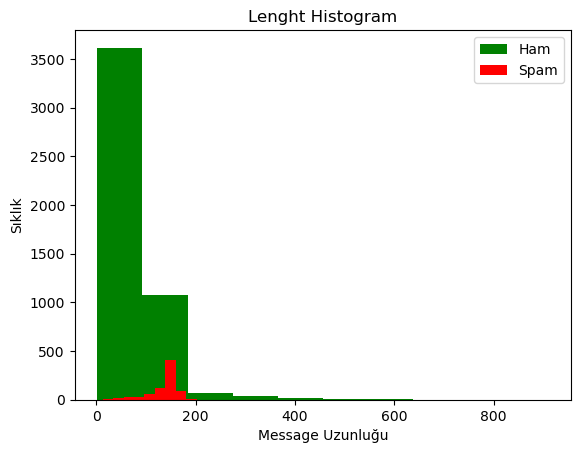

In [12]:
# mesajların uzunluğu ile ham-spam olması arasındaki bağlantı
plt.hist(df[df['labels']==0]['len'],label="Ham",color='green')
plt.hist(df[df['labels']==1]['len'],label="Spam",color='red')
plt.title("Lenght Histogram")
plt.xlabel('Message Uzunluğu')
plt.ylabel('Sıklık')
plt.legend()
plt.show()

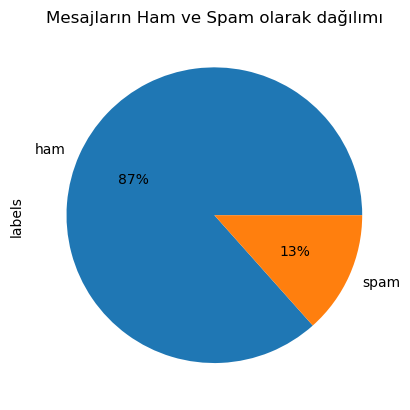

In [13]:
is_spam=pd.value_counts(df['labels'],sort=True)
is_spam.plot(kind="pie",labels=["ham", "spam"],autopct="%1.0f%%")
plt.title("Mesajların Ham ve Spam olarak dağılımı")
plt.show()

## 2- Veri Ön İşleme
Bu aşama elimizdeki corpus'ta yani verimizde bulunan büyük-küçük harf dönüşümleri, noktalama işaretlerinin silinmesi veya bunların her bir satır için sayısını elde ederek özellik çıkarımı yapılması, eğer gerekli ise az geçen kelimelerin silinmesi, tokenization, stemming ve lemmatization işlemlerinin yapıldığı aşamadır. Veriyi hazırlama aşaması da denilebilir.

In [14]:
import nltk
from nltk.corpus import stopwords
import textblob
from textblob import Word
import re
sw=stopwords.words("english")

In [15]:
df["clean_message"]=df["message"].apply(lambda x: re.sub(r'[^\w\s]','',x)) # noktalama işaretlerinin silinmesi

In [16]:
df["clean_message"]=df["clean_message"].apply(lambda x: re.sub(r'[0-9]+','',x)) # sayıların silinmesi

In [17]:
df["clean_message"]=df["clean_message"].apply(lambda x: " ".join(x for x in x.split() if x not in sw)) 
# stopwordslerin silinmesi

In [18]:
df["clean_message"]=df["clean_message"].apply(lambda x: " ".join(Word(i).lemmatize() for i in x.split())) # lemmatization

In [19]:
df["clean_message"]=df["clean_message"].apply(lambda x:" ".join(i.lower() for i in x.split())) # büyük-küçük harf dönüşümü

In [20]:
df

,message,labels,len,clean_message
0,"Go until jurong point, crazy.. Available only ...",0,111,go jurong point crazy available bugis n great ...
1,Ok lar... Joking wif u oni...,0,29,ok lar joking wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,free entry wkly comp win fa cup final tkts st ...
3,U dun say so early hor... U c already then say...,0,49,u dun say early hor u c already say
4,"Nah I don't think he goes to usf, he lives aro...",0,61,nah i dont think go usf life around though
...,...,...,...,...
5567,This is the 2nd time we have tried 2 contact u...,1,160,this nd time tried contact u u pound prize cla...
5568,Will ü b going to esplanade fr home?,0,36,will ü b going esplanade fr home
5569,"Pity, * was in mood for that. So...any other s...",0,57,pity mood soany suggestion
5570,The guy did some bitching but I acted like i'd...,0,125,the guy bitching i acted like id interested bu...


# Sınıflandırma

## 3- Veriyi Makine Öğrenmesine Hazırlamak
Aslında bakarsak makine öğrenmesine kadar yapılan her işlem veriyi makine öğrenmesine hazırlama işlemidir. Fakat burada belirtilmek istenen durum artık veri üzerinde en son işlemlerin yapıldığı, makine öğrenme algoritmalarının sonucuda etkili olacak ayarlamaların yapıldığı ve gerektiğinde bu ayarların değiştirildiği aşamadır.


In [21]:
# Verilerimizi X,Y olarak bölyoruz. X'de modelimizi eğitmek için bulunan temizlenmiş mesajları,
# Y'de ise bu mesajların hangi tür olduğunu tutuyoruz.
X=df["clean_message"]
Y=df["labels"]

In [22]:
X.shape,Y.shape

((5572,), (5572,))

Şimdi ise ayırdığımız X ve Y değerlerini aşağıda CountVectorizer fonksiyonu ile birlikte kullanacağız. Peki bu fonksiyon nedir, ne işe yarar ?

CountVectorizer, verilen bir metni(corpusu) özelliklerin geçme sıklığı matrisine (yani vektöre) çeviren bir fonksiyondur.

cv=CountVectorizer(max_features=2500) ifadeside yer alan max_features parametresini göz önüne alalım. Bu parametre kesinlikle isteğe bağlıdır ve eldeki veri setinin içeriğine göre değerlendirilip yazılmalıdır. Burada yaptığı işlem 5571 metin arasında kelime frekanslarına bakarak en verimli, en çok 2500 kelime frekansını alır. Yani bazen tüm kelime dağarcığını dönüştürmek etkili değildir, çünkü eğer son derece nadir(frekansı az) bulunan veriler geçilirse(dönüştürülürse) gelecekte girdilere istenmeyen boyutlar katacaktır. Bu durumda uygun tekniklerden biri, corpustaki kelime frekanslarını yazdırmak ve daha sonra bunlar için belirli bir eşik belirlemek olabilir. 50'lik bir eşik belirlediğinizi ve veri topluluğunuzun 100 kelimeden oluştuğunu düşünün. Sözcük frekanslarına baktıktan sonra 20 sözcük, 50'den az kez geçiyorsa(frekansı). Böylece, max_features=80 olarak belirlemek modeliniz için daha iyi olacaktır.

Burada fit_transform().toarray() ifadesine geçmeden önce ayrı ayrı fit() ve transform() işlemlerini açıklayalım. Öncelikle bu iki fonksiyonun da temel işlevleri, eğitim ve test verilerimizi ölçeklendirirken veya standartlaştırırken kullanılmalarıdır. Ve hemen hemen her zaman birlikte kullanılırlar.

fit(): Eğitim verilerinden öğrenme modeli parametreleri oluşturmak için kullanılır. Verilerimizde bulunan özelliklerin her birinin ortalamasını ve varyansını hesaplıyor.

transform(): fit() yönteminden üretilen verilerin ilgili ortalama ve varyansı kullanarak tüm özellikleri dönüştürür.

fit_transform(): Eğitim verilerini ölçeklendirebilmemiz ve ayrıca bu verilerin ölçeklendirme parametrelerini öğrenebilmemiz için eğitim verilerinde fit_transform () kullanılır. Burada oluşturduğumuz model, eğitim setinin özelliklerinin ortalamasını ve varyansını öğrenecek. Öğrenilen bu parametreler daha sonra test verilerimizi ölçeklendirmek için kullanılır.

In [23]:
cv=CountVectorizer(max_features=2500)
X=cv.fit_transform(X).toarray()
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [24]:
Y=np.array(Y)
Y

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

## Train and Test split
Bu aşamada artık verilerimizi eğitim ve test olarak ayırıp daha sonra farklı makine öğrenme modelleri ile makine öğrenmesi geliştirerek hangisinin daha başarılı sonuçlar vereceğini gözlemleyeceğiz

Bu işlem için sklearnde train_test_split() fonksiyonu bulunmaktadır. Bu fonksiyon içerisine yukarıda vektörleştirdiğimiz X ve Y ve değerlerini, test_size denilen verinin kaçta kaçını test için kullanacağımızı belirttiğimiz parametreyi ve random_state denilen bir parametre alır.

random_state: Oluşturduğumuz bölmelerin yeniden üretilebilir olmasını sağlar. Scikit-learn, bölünmeleri oluşturmak için rastgele permütasyonlar kullanır. random_state, rastgele sayı oluşturucu için bir çekirdek olarak kullanılır. Bu, rastgele sayıların aynı sırada üretilmesini sağlar.Eğer kodda random_state belirtmezsek, kodumuzu her çalıştırdığımızda yeni bir rastgele değer üretilir ve eğitim ve test veri kümeleri her seferinde farklı değerlere sahip olur. Bununla birlikte, random_state = 0, 1, 42 veya başka bir tam sayı gibi sabit bir değer atanırsa, kodumuzu kaç kez çalıştırırsak çalıştıralım, sonuç aynı kalır ve doalyısı ile eğitim ve test veri kümelerinde aynı değerler olacaktır.

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state = 1)

In [26]:
# Eğitim ve test verilerimizin boyutları
print("X_train shape: {}\nY_train shape: {}\nX_test shape: {}\nY_test shape: {}"
      .format(X_train.shape,X_test.shape,y_train.shape,y_test.shape))

X_train shape: (4179, 2500)
Y_train shape: (1393, 2500)
X_test shape: (4179,)
Y_test shape: (1393,)


In [27]:
# bütün accuracy skorlarını karşılaştırmak için her biri listeye ekleyeceğiz
acc=[]

## 4- Makine Öğrenmesi Algoritmaları ve Doğru Algoritma Seçimi

Bu aşamada sınıflandırma adı altında bulunan:

- Decision Tree
- Random Forest


sınıflandırıcıları kullanılarak hangisinin veri setine en iyi uyum sağladığını gözlemleyeceğiz.

In [28]:
# gerekli kütüphaneler import edildi
from sklearn import metrics
from sklearn.model_selection import cross_val_score,StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from math import sqrt

## Decision Tree

In [29]:
# Gini kriteri için sınıflandırma modeli
dtree = DecisionTreeClassifier(criterion='gini')
dtree.fit(X_train, y_train)
y_pred = dtree.predict(X_test)
cv_score=cross_val_score(dtree, X, Y, cv=5, scoring='accuracy',n_jobs=-1).mean()
print("Decision Tree Cross Validation (K=5) Accuracy: {}".format(cv_score))
print('-'*100)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
print('MSE {} \nRMSE {}'.format(mse, rmse))
acc.append(metrics.accuracy_score(y_test, y_pred))

Decision Tree Cross Validation (K=5) Accuracy: 0.9578220930513399
----------------------------------------------------------------------------------------------------
[[1169   39]
 [  28  157]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1208
           1       0.80      0.85      0.82       185

    accuracy                           0.95      1393
   macro avg       0.89      0.91      0.90      1393
weighted avg       0.95      0.95      0.95      1393

MSE 0.04809763101220388 
RMSE 0.21931172110082006


In [30]:
# Entropi kriteri için sınıflandırma modeli
dtree = DecisionTreeClassifier(criterion='entropy')
dtree.fit(X_train, y_train)
y_pred = dtree.predict(X_test)
cv_score=cross_val_score(dtree, X, Y, cv=5, scoring='accuracy',n_jobs=-1).mean()
print("Decision Tree Cross Validation (K=5) Accuracy: {}".format(cv_score))
print('-'*100)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
print('MSE {} \nRMSE {}'.format(mse, rmse))
acc.append(metrics.accuracy_score(y_test, y_pred))

Decision Tree Cross Validation (K=5) Accuracy: 0.9567468259654943
----------------------------------------------------------------------------------------------------
[[1175   33]
 [  30  155]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1208
           1       0.82      0.84      0.83       185

    accuracy                           0.95      1393
   macro avg       0.90      0.91      0.90      1393
weighted avg       0.96      0.95      0.95      1393

MSE 0.04522613065326633 
RMSE 0.2126643615025008


Gini kriteri için toplam hatalı tahmin sayısı, entropy kriteri için toplam hatalı tahmin sayısından daha az bulunmuştur. Ayrıca her iki kriter için yapılan tahminlemenin doğruluk değerleri incelendiğinde biraz daha doğru tahminleme için gini kriterini seçmek daha iyi olacaktır. Bu tahminlemenin doğruluğunu MSE ve RMSE değerlendirmelerinden de anlayabiliriz. 

Modelimize budama işlemi yapıp sonuçları kıyaslayalım.

In [31]:
dtree=DecisionTreeClassifier(criterion='gini')
path=dtree.cost_complexity_pruning_path(X_train,y_train)
alphas_gini=path['ccp_alphas']

In [32]:
acc_train_gini,acc_test_gini=[],[]

for i in alphas_gini:
    dtree=DecisionTreeClassifier(criterion='gini',ccp_alpha=i, max_depth=10)
    
    dtree.fit(X_train,y_train)
    y_train_pred=dtree.predict(X_train)
    y_test_pred=dtree.predict(X_test)
    
    acc_train_gini.append(accuracy_score(y_train,y_train_pred))
    acc_test_gini.append(accuracy_score(y_test,y_test_pred))

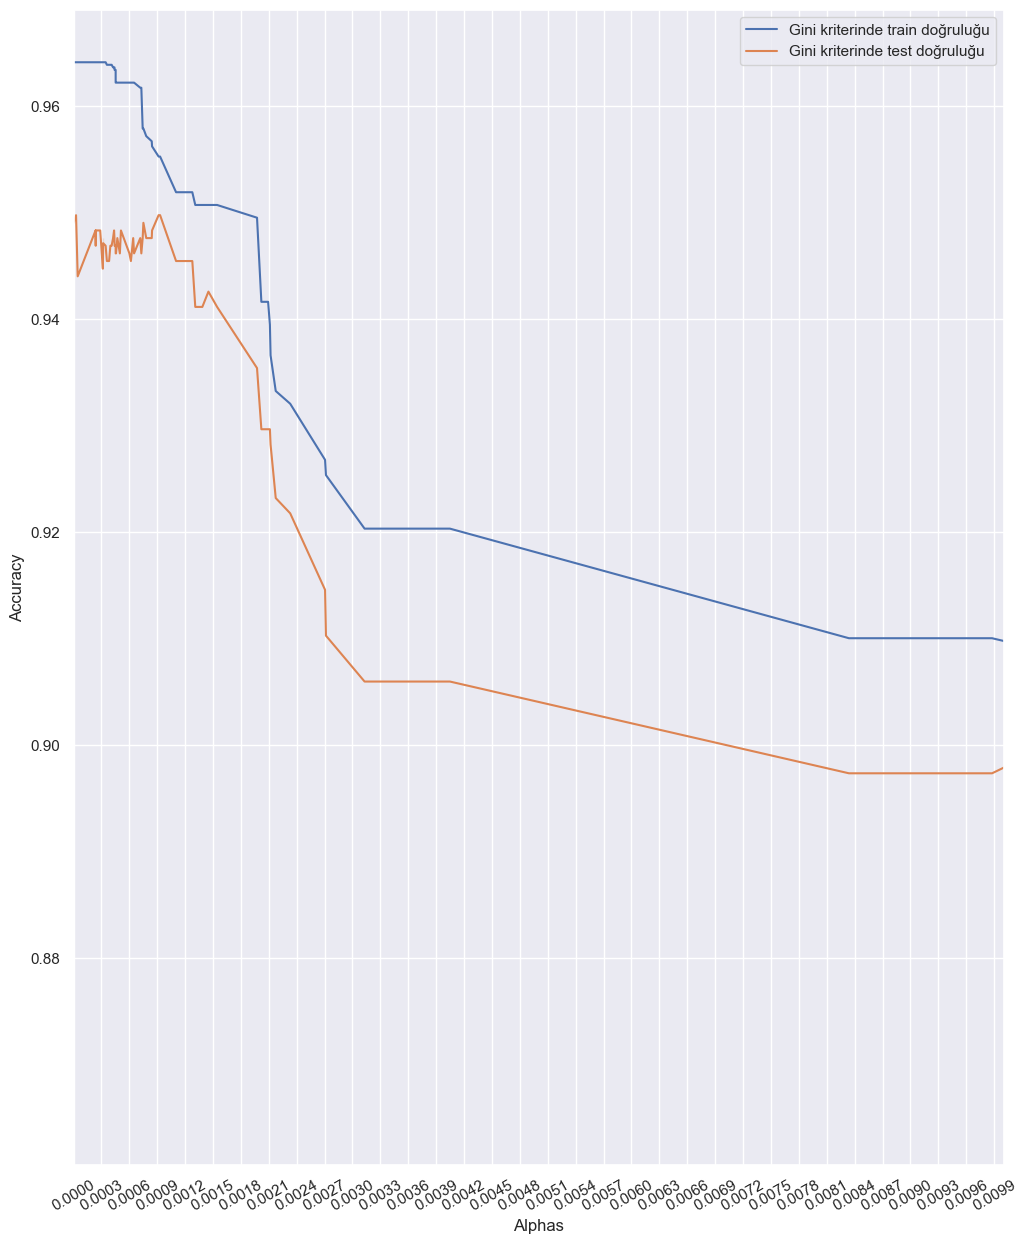

In [33]:
sns.set()
plt.figure(figsize=(12,15))
plt.xlabel('Alphas')
plt.ylabel('Accuracy')
sns.lineplot(y=acc_train_gini,x=alphas_gini,label='Gini kriterinde train doğruluğu')
sns.lineplot(y=acc_test_gini,x=alphas_gini,label='Gini kriterinde test doğruluğu')
plt.xticks(ticks=np.arange(0.00,0.010,0.0003),rotation=30)
plt.xlim(xmax=0.01, xmin=0.00)
plt.show()

Budama işlemi sonucunda elde edilen doğruluk değerleri incelendiğinde hem train hem de test için en iyi alfa değerinin 0.0009 olarak seçilebileceğini görülmektedir.

Şimdi bu alfa değerine göre 'gini' kriteri ile bir model daha oluşturalım.

In [34]:
# Gini kriteri için sınıflandırma modeli
dtree = DecisionTreeClassifier(criterion='gini',ccp_alpha=0.0009)
dtree.fit(X_train, y_train)
y_pred = dtree.predict(X_test)
cv_score=cross_val_score(dtree, X, Y, cv=5, scoring='accuracy',n_jobs=-1).mean()
print("Decision Tree Cross Validation (K=5) Accuracy: {}".format(cv_score))
print('-'*100)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
print('MSE {} \nRMSE {}'.format(mse, rmse))
acc.append(metrics.accuracy_score(y_test, y_pred))

Decision Tree Cross Validation (K=5) Accuracy: 0.9556704317653025
----------------------------------------------------------------------------------------------------
[[1193   15]
 [  38  147]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1208
           1       0.91      0.79      0.85       185

    accuracy                           0.96      1393
   macro avg       0.94      0.89      0.91      1393
weighted avg       0.96      0.96      0.96      1393

MSE 0.03804737975592247 
RMSE 0.19505737554863817


Görüldüğü gibi budama işlemi sonucu hem train hem de test verilerinde başarı ciddi boyutta yükselmiş, komşuluk matrisi iyileşmiş ve MSE, RMSE değerleri gözle görülür boyutta azalmıştır. Yani budamak için seçilen alfa değeri doğru seçilmiştir.

Şimdi ise ağaç büyüklüğü, düğüm ve yaprak sayıları için en optimal değerler aranacaktır.

In [35]:
from sklearn.model_selection import GridSearchCV

In [36]:
dtree = DecisionTreeClassifier(criterion='gini',ccp_alpha=0.0009)

In [37]:
max_depth = range(1, 30, 2)
print(max_depth)
param_grid = dict(max_depth=max_depth)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(dtree, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold, verbose=1)

range(1, 30, 2)


In [38]:
grid_result = grid_search.fit(X, Y)

Fitting 10 folds for each of 15 candidates, totalling 150 fits


Best: -0.195255 using {'max_depth': 25}
-0.327064 (0.016568) with: {'max_depth': 1}
-0.243120 (0.026330) with: {'max_depth': 3}
-0.227669 (0.039991) with: {'max_depth': 5}
-0.214470 (0.052209) with: {'max_depth': 7}
-0.206350 (0.051356) with: {'max_depth': 9}
-0.206496 (0.063217) with: {'max_depth': 11}
-0.199934 (0.066166) with: {'max_depth': 13}
-0.197172 (0.065224) with: {'max_depth': 15}
-0.196708 (0.064952) with: {'max_depth': 17}
-0.197025 (0.067046) with: {'max_depth': 19}
-0.196752 (0.064351) with: {'max_depth': 21}
-0.200247 (0.067314) with: {'max_depth': 23}
-0.195255 (0.063403) with: {'max_depth': 25}
-0.202898 (0.067835) with: {'max_depth': 27}
-0.196489 (0.068347) with: {'max_depth': 29}


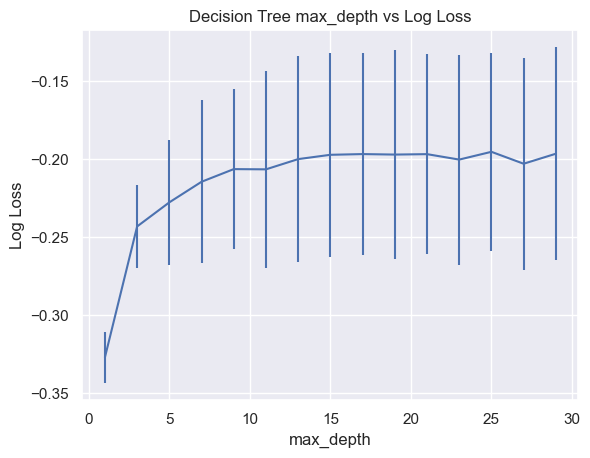

In [39]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
# plot
plt.errorbar(max_depth, means, yerr=stds)
plt.title("Decision Tree max_depth vs Log Loss")
plt.xlabel('max_depth')
plt.ylabel('Log Loss')
plt.show()

Grafikten anlaşılacağa üzere Log loss değerini yani modelin başarısızlık değerini minimuma en çok yaklaştıran max_depth değeri 15'tir. Bu nedenle bu değerle işlemlerimize devam edeceğiz.

In [40]:
dtree = DecisionTreeClassifier(criterion='gini',ccp_alpha=0.0009)

In [41]:
min_samples_leaf=range(1,10,1)
max_depth=[11,13,15,17]
param_grid = dict(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(dtree, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold, verbose=1)

In [42]:
grid_result = grid_search.fit(X, Y)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


Best: -0.190646 using {'max_depth': 15, 'min_samples_leaf': 3}
-0.205928 (0.062625) with: {'max_depth': 11, 'min_samples_leaf': 1}
-0.207716 (0.062657) with: {'max_depth': 11, 'min_samples_leaf': 2}
-0.207152 (0.062921) with: {'max_depth': 11, 'min_samples_leaf': 3}
-0.207252 (0.063327) with: {'max_depth': 11, 'min_samples_leaf': 4}
-0.206433 (0.062886) with: {'max_depth': 11, 'min_samples_leaf': 5}
-0.208717 (0.062459) with: {'max_depth': 11, 'min_samples_leaf': 6}
-0.210705 (0.063268) with: {'max_depth': 11, 'min_samples_leaf': 7}
-0.203465 (0.056805) with: {'max_depth': 11, 'min_samples_leaf': 8}
-0.203787 (0.056392) with: {'max_depth': 11, 'min_samples_leaf': 9}
-0.199522 (0.064785) with: {'max_depth': 13, 'min_samples_leaf': 1}
-0.198594 (0.065911) with: {'max_depth': 13, 'min_samples_leaf': 2}
-0.198104 (0.064384) with: {'max_depth': 13, 'min_samples_leaf': 3}
-0.200282 (0.065509) with: {'max_depth': 13, 'min_samples_leaf': 4}
-0.199487 (0.065074) with: {'max_depth': 13, 'min_sam

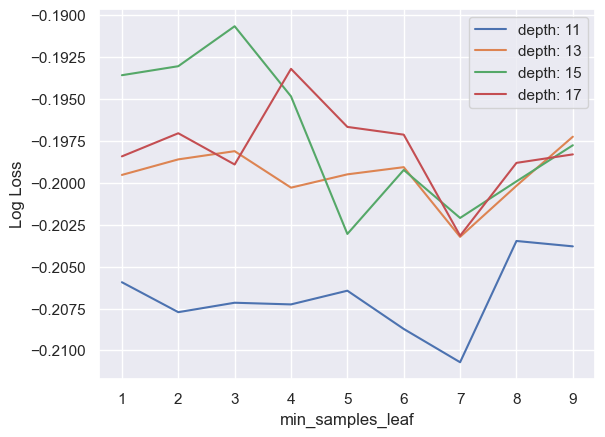

In [43]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
# plot results
scores = numpy.array(means).reshape(len(max_depth), len(min_samples_leaf))
for i, value in enumerate(max_depth):
    plt.plot(min_samples_leaf, scores[i], label='depth: ' + str(value))
plt.legend()
plt.xlabel('min_samples_leaf')
plt.ylabel('Log Loss')
plt.show()

Görüleceği üzere min_samples_leaf değerinin 2, max_depth değerinin 15 olduğu nokta için modelimizin performans kaybı en minimal seviyededir.

In [44]:
dtree = DecisionTreeClassifier(criterion='gini',ccp_alpha=0.0009,max_depth=15,min_samples_leaf=2)

In [45]:
min_samples_split=range(2,30,1)
param_grid = dict(min_samples_split=min_samples_split)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(dtree, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold, verbose=1)

In [46]:
grid_result = grid_search.fit(X, Y)

Fitting 10 folds for each of 28 candidates, totalling 280 fits


Best: -0.190051 using {'min_samples_split': 3}
-0.194169 (0.062423) with: {'min_samples_split': 2}
-0.190051 (0.063213) with: {'min_samples_split': 3}
-0.195154 (0.065490) with: {'min_samples_split': 4}
-0.193248 (0.064646) with: {'min_samples_split': 5}
-0.194752 (0.065438) with: {'min_samples_split': 6}
-0.194641 (0.064089) with: {'min_samples_split': 7}
-0.191829 (0.061728) with: {'min_samples_split': 8}
-0.202430 (0.068488) with: {'min_samples_split': 9}
-0.191430 (0.063923) with: {'min_samples_split': 10}
-0.195870 (0.064782) with: {'min_samples_split': 11}
-0.195169 (0.064857) with: {'min_samples_split': 12}
-0.194833 (0.063947) with: {'min_samples_split': 13}
-0.192309 (0.061936) with: {'min_samples_split': 14}
-0.191543 (0.061880) with: {'min_samples_split': 15}
-0.193306 (0.064426) with: {'min_samples_split': 16}
-0.195360 (0.067456) with: {'min_samples_split': 17}
-0.195552 (0.064491) with: {'min_samples_split': 18}
-0.192847 (0.061717) with: {'min_samples_split': 19}
-0.1938

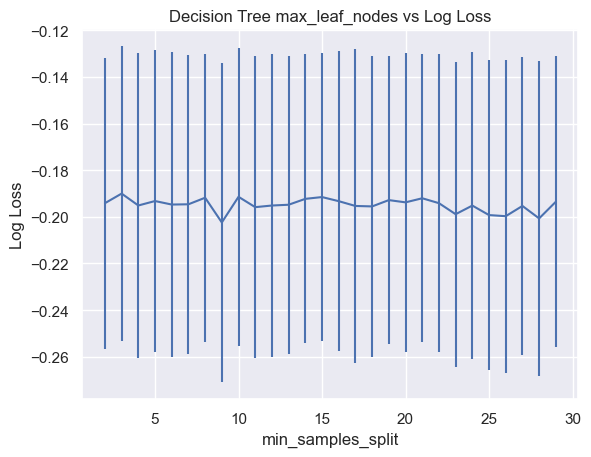

In [47]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
# plot
plt.errorbar(min_samples_split, means, yerr=stds)
plt.title("Decision Tree max_leaf_nodes vs Log Loss")
plt.xlabel('min_samples_split')
plt.ylabel('Log Loss')
plt.show()

Grafikten gözlemlendiği gibi minimum hatayı aldığımız min_samples_split değeri 17'tir. 

Tüm bu bulunan değerleri kullanarak bir model oluşturalım ve başarısını gözlemleyelim.

In [48]:
# Yukarıda bulunan optimal değerler ile oluşturulan son sınıflandırma modeli
dtree = DecisionTreeClassifier(criterion='gini',ccp_alpha=0.0009,max_depth=15,min_samples_leaf=2,min_samples_split=17)
dtree.fit(X_train, y_train)
y_pred = dtree.predict(X_test)
cv_score=cross_val_score(dtree, X, Y, cv=5, scoring='accuracy',n_jobs=-1).mean()
print("Decision Tree Cross Validation (K=5) Accuracy: {}".format(cv_score))
print('-'*100)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
print('MSE {} \nRMSE {}'.format(mse, rmse))
acc.append(metrics.accuracy_score(y_test, y_pred))

Decision Tree Cross Validation (K=5) Accuracy: 0.954054793858837
----------------------------------------------------------------------------------------------------
[[1193   15]
 [  42  143]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1208
           1       0.91      0.77      0.83       185

    accuracy                           0.96      1393
   macro avg       0.94      0.88      0.91      1393
weighted avg       0.96      0.96      0.96      1393

MSE 0.040918880114860015 
RMSE 0.20228415685579534


Tüm optimal değerler ile kurulan modelin başarısı en başta kurulan modelden çok daha iyidir. Fakat tek başına ccp_alpha yani budamamızı belirleyen parametre ve gini kriteri ile kurulan modelin başarısı halen en iyisidir. Bu nedenle model seçimini kriter gini ve ccp_alpha 0.0009 değerlerine sahip modelden yana yapmalıyız.

## Random Forest

In [49]:
Random_forest = RandomForestClassifier(criterion='gini')
Random_forest.fit(X_train,y_train)
y_pred = Random_forest.predict(X_test)
cv_score=cross_val_score(Random_forest, X, Y, cv=5, scoring='accuracy',n_jobs=-1).mean()
print("Random Forest Cross Validation (K=5) Accuracy: {}".format(cv_score))
print('-'*100)
print("Confusion Matrix \n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
print('MSE {} \nRMSE {}'.format(mse, rmse))
acc.append(metrics.accuracy_score(y_test, y_pred))

Random Forest Cross Validation (K=5) Accuracy: 0.9755910507120946
----------------------------------------------------------------------------------------------------
Confusion Matrix 
 [[1206    2]
 [  24  161]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1208
           1       0.99      0.87      0.93       185

    accuracy                           0.98      1393
   macro avg       0.98      0.93      0.96      1393
weighted avg       0.98      0.98      0.98      1393

MSE 0.01866475233309404 
RMSE 0.13661900428964502


In [50]:
Random_forest = RandomForestClassifier(criterion='entropy')
Random_forest.fit(X_train,y_train)
y_pred = Random_forest.predict(X_test)
cv_score=cross_val_score(Random_forest, X, Y, cv=5, scoring='accuracy',n_jobs=-1).mean()
print("Random Forest Cross Validation (K=5) Accuracy: {}".format(cv_score))
print('-'*100)
print("Confusion Matrix \n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
print('MSE {} \nRMSE {}'.format(mse, rmse))
acc.append(metrics.accuracy_score(y_test, y_pred))

Random Forest Cross Validation (K=5) Accuracy: 0.974514495495568
----------------------------------------------------------------------------------------------------
Confusion Matrix 
 [[1206    2]
 [  29  156]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1208
           1       0.99      0.84      0.91       185

    accuracy                           0.98      1393
   macro avg       0.98      0.92      0.95      1393
weighted avg       0.98      0.98      0.98      1393

MSE 0.022254127781765973 
RMSE 0.14917817461601404


Gini kriteri için toplam hatalı tahmin sayısı, entropy kriteri için toplam hatalı tahmin sayısından daha az bulunmuştur. Ayrıca her iki kriter için yapılan tahminlemenin doğruluk değerleri incelendiğinde biraz daha doğru tahminleme için gini kriterini seçmek daha iyi olacaktır. Bu tahminlemenin doğruluğunu MSE ve RMSE değerlendirmelerinden de anlayabiliriz.

Modelimize budama işlemi yapıp sonuçları kıyaslayalım.

Çok derin veya tam derinliğe sahip bir karar ağacı, verilerdeki gürültüyü öğrenme eğilimindedir. Düşük yanlılığa, ancak yüksek varyansa neden olan verilere fazla uyuyorlar. Budama, fazla uydurmayı azaltmak için karar ağaçlarında kullanılan uygun bir yaklaşımdır.

Ancak, genellikle rastgele ormanlar, tam derinlikte iyi performans verir. Rastgele orman eğitimi, bir bölme için rastgele bir özellik seçimi ile birlikte önyükleme toplama (veya değiştirme ile örnekleme) kullandığından, ağaçlar (veya zayıf öğrenenler) arasındaki korelasyon düşük olacaktır. Bu, tek tek ağaçların yüksek varyansa sahip olmasına rağmen, topluluk çıktısının uygun olacağı anlamına gelir (daha düşük varyans ve daha düşük sapma), çünkü ağaçlar korelasyonlu değildir.

Yine de rastgele bir ormandaki eğitimi kontrol etmek istenirse, budama yerine ağaç derinliğini kontrol etmeye gidilmelidir.

In [51]:
Random_forest = RandomForestClassifier(criterion='gini')

In [52]:
max_depth = range(20, 50, 2)
print(max_depth)
param_grid = dict(max_depth=max_depth)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(Random_forest, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold, verbose=1)

range(20, 50, 2)


In [53]:
grid_result = grid_search.fit(X, Y)

Fitting 10 folds for each of 15 candidates, totalling 150 fits


Best: -0.090711 using {'max_depth': 48}
-0.145994 (0.013394) with: {'max_depth': 20}
-0.139164 (0.012457) with: {'max_depth': 22}
-0.130803 (0.011814) with: {'max_depth': 24}
-0.125572 (0.013067) with: {'max_depth': 26}
-0.119304 (0.013674) with: {'max_depth': 28}
-0.115131 (0.012776) with: {'max_depth': 30}
-0.110682 (0.012347) with: {'max_depth': 32}
-0.107095 (0.013687) with: {'max_depth': 34}
-0.104296 (0.013303) with: {'max_depth': 36}
-0.101257 (0.012364) with: {'max_depth': 38}
-0.097774 (0.012997) with: {'max_depth': 40}
-0.094936 (0.013102) with: {'max_depth': 42}
-0.094102 (0.013495) with: {'max_depth': 44}
-0.094237 (0.013793) with: {'max_depth': 46}
-0.090711 (0.013380) with: {'max_depth': 48}


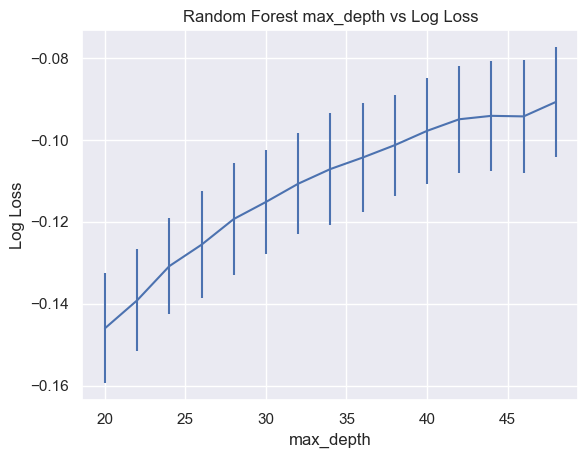

In [54]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
# plot
plt.errorbar(max_depth, means, yerr=stds)
plt.title("Random Forest max_depth vs Log Loss")
plt.xlabel('max_depth')
plt.ylabel('Log Loss')
plt.show()

Görüldüğü gibi max_depth değerni ne kadar büyük alırsak (yani ağacı budamazsak) performans o derece daha fazla olacaktır. Bu nedenle Random Forest modelinde budalama yapmıyoruz ve direkt gini kritere göre modeli değerlendiriyoruz.

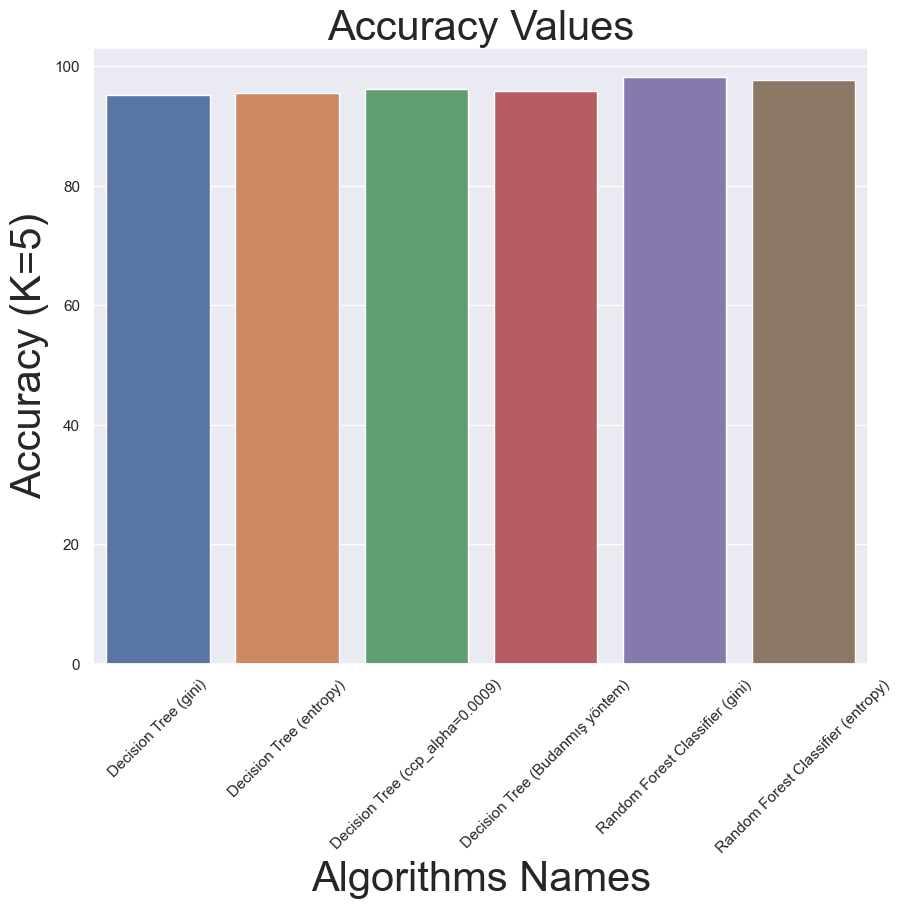

In [55]:
algo_name=['Decision Tree (gini)','Decision Tree (entropy)','Decision Tree (ccp_alpha=0.0009)',\
           'Decision Tree (Budanmış yöntem)','Random Forest Classifier (gini)','Random Forest Classifier (entropy)']
acc=np.array(acc)
from numpy import median
plt.figure(figsize=(10,8))
sns.barplot(y=acc*100,x=algo_name,estimator=median)
plt.title("Accuracy Values",size=30)
plt.xlabel('Algorithms Names',size=30)
plt.xticks(rotation=45)
plt.ylabel('Accuracy (K=5)',size=30)
plt.show()

## 5- Değerlendirme ve Sonuç

Şuana kadar algoritmaların her birinde kriterlere, ağaç büyüklüğüne, düğüm ve yaprak sayılarına göre modeller kurulmuş ve en iyi sonucu üreten modol keşfedilmiştir.

Grafikte de görüldüğü üzere en başarılı(accuracy) algoritma 0.98'e yakın değeri ile <b> Random Forest (gini) </b>'dur.(Cross-validation kullanıldığından tam bir skor değeri yazmak doğru görülmemiştir).

Random Forest (gini) algoritmasının F1 score değerleri ortalaması 0.95 bulunmuştur. Diğer temel değerlendirme kriterlerine bakacak olursak:
- Kesinlik (Precision): Positive olarak tahminlediğimiz değerlerin gerçekten kaç adetinin Positive olduğunu göstermektedir.
- Duyarlılık (Recall): Positive olarak tahmin etmemiz gereken işlemlerin ne kadarını Positive olarak tahmin ettiğimizi gösteren bir metriktir.

F1 score: Kesinlik (Precision) ve Duyarlılık (Recall) değerlerinin harmonik ortalamasını göstermektedir.

Bu sonuçlar dahilinde modelimizi test etmek için aşağıda rastgele mesajar oluşturalım ve modelimizin tahminini inceleyelim.

# Kümeleme (Spam Veri Seti İle)

Kullandığımız veri seti kümeleme için de uygun olduğundan, sınıflandırma için yapılan ön işleme adımları kümeleme için de yapılabilir. Bu nedenle sınıflandırma ve kümeleme aynı dosya da işlencektir.

Kümeleme aslında bir denetimsiz sınıflandırmadır. Kullanılacak algoritma türlerinen göre kümeler farklı farklı oluşabilir.

In [56]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [57]:
X=df["clean_message"]

In [58]:
def feature_extraction(df,choice):
    if choice == 1:
        print("TF-IDF yöntemi seçildi")
        vectorizer = TfidfVectorizer(lowercase=False,ngram_range=(1, 2),dtype=np.float32)
        X = vectorizer.fit_transform(df['clean_message'].tolist())
        vocab = vectorizer.get_feature_names()
        return X,vocab
    if choice == 2:
        print("BoW yöntemi seçildi")
        vectorizer=CountVectorizer(lowercase=False,dtype=np.float32,ngram_range=(1,2))
        X=vectorizer.fit_transform(df['clean_message'].tolist())
        vocab = vectorizer.get_feature_names()
        return X,vocab

In [59]:
X,vocab=feature_extraction(df,1)

TF-IDF yöntemi seçildi


In [60]:
X.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [61]:
def elbow(X):
    number_clusters = range(1, 10)  # Range of possible clusters that can be generated
    kmeans = [KMeans(n_clusters=i, max_iter = 600) for i in number_clusters] # Getting no. of clusters 

    score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))] # Getting score corresponding to each cluster.
    score = [i*-1 for i in score] # Getting list of positive scores.

    plt.plot(number_clusters, score)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    plt.title('Elbow Method')
    plt.show()


In [62]:
from sklearn.decomposition import PCA

In [63]:
pca = PCA(n_components=5)

In [64]:
pca_X=pca.fit_transform(X.toarray())

In [65]:
pca_df=pd.DataFrame(data = pca_X, columns = range(1,6))

In [66]:
pca_df = pd.concat([pca_df, df['labels']], axis = 1)

In [67]:
pca_X

array([[-0.01597441, -0.01155796, -0.01385432, -0.01999073,  0.03155809],
       [-0.0228685 ,  0.17033781, -0.00280404, -0.00322624,  0.00100049],
       [-0.01319285, -0.01574709,  0.02485355,  0.01161339, -0.03493724],
       ...,
       [-0.01198616, -0.00932136, -0.00784307, -0.00511794,  0.00192829],
       [-0.0153013 , -0.01610604, -0.00406767, -0.00096088, -0.01158517],
       [-0.01507671, -0.00927889, -0.01333629, -0.00493641,  0.00054835]],
      dtype=float32)

In [68]:
num_clusters = 3
km = KMeans(num_clusters,random_state=99)
fitted=km.fit_predict(pca_X)
clusters = km.labels_.tolist()

In [69]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(pca_df['labels'], km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(pca_df['labels'], km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(pca_df['labels'], km.labels_))
print("Adjusted Rand-Index: %.3f" % metrics.adjusted_rand_score(pca_df['labels'], km.labels_))
print(
    "Silhouette Coefficient: %0.3f"
    % metrics.silhouette_score(pca_X, km.labels_)
)

Homogeneity: 0.004
Completeness: 0.024
V-measure: 0.008
Adjusted Rand-Index: -0.019
Silhouette Coefficient: 0.907


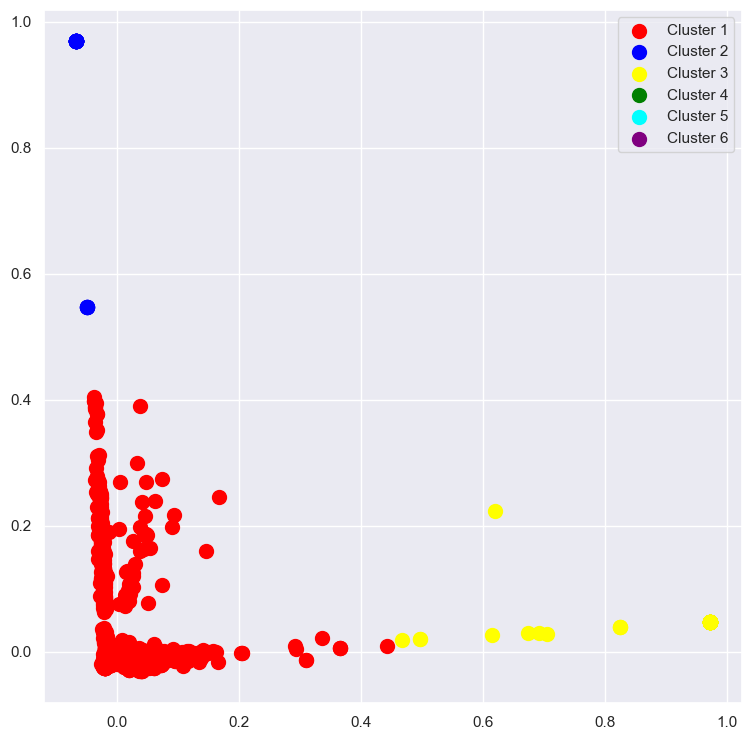

In [70]:
plt.figure(figsize =(9, 9))
plt.scatter(pca_X[fitted == 0, 0], pca_X[fitted == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(pca_X[fitted == 1, 0], pca_X[fitted == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(pca_X[fitted == 2, 0], pca_X[fitted == 2, 1], s = 100, c = 'yellow', label = 'Cluster 3')
plt.scatter(pca_X[fitted == 3, 0], pca_X[fitted == 3, 1], s = 100, c = 'green', label = 'Cluster 4')
plt.scatter(pca_X[fitted == 4, 0], pca_X[fitted == 4, 1], s = 100, c = 'cyan', label = 'Cluster 5')
plt.scatter(pca_X[fitted == 5, 0], pca_X[fitted == 5, 1], s = 100, c = 'purple', label = 'Cluster 6')
plt.legend()
plt.show()

In [71]:
from sklearn.mixture import GaussianMixture

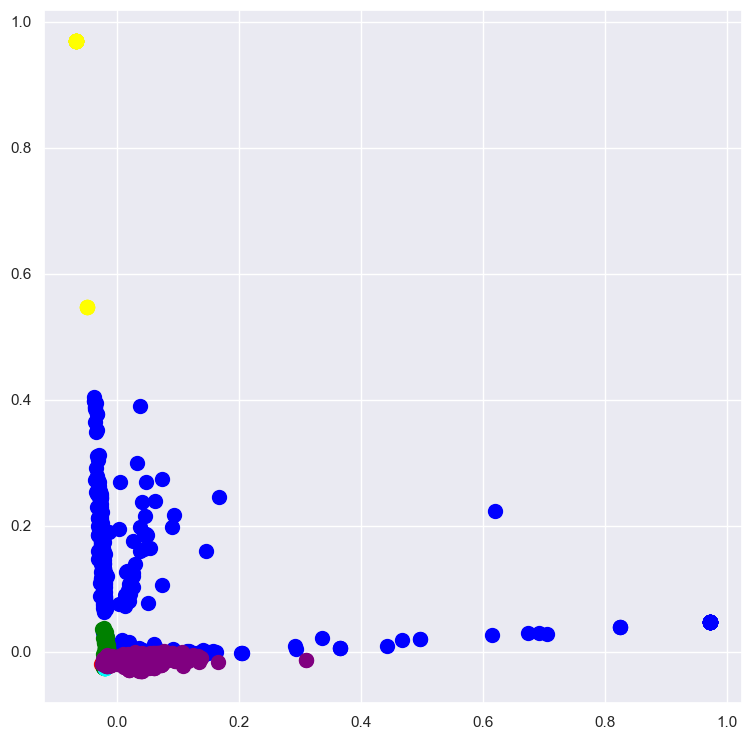

In [72]:
plt.figure(figsize =(9, 9))
gmm = GaussianMixture(n_components=6)
labels = gmm.fit_predict(pca_X)
plt.scatter(pca_X[labels == 0, 0], pca_X[labels == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(pca_X[labels == 1, 0], pca_X[labels == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(pca_X[labels == 2, 0], pca_X[labels == 2, 1], s = 100, c = 'yellow', label = 'Cluster 3')
plt.scatter(pca_X[labels == 3, 0], pca_X[labels == 3, 1], s = 100, c = 'green', label = 'Cluster 4')
plt.scatter(pca_X[labels == 4, 0], pca_X[labels == 4, 1], s = 100, c = 'cyan', label = 'Cluster 5')
plt.scatter(pca_X[labels == 5, 0], pca_X[labels == 5, 1], s = 100, c = 'purple', label = 'Cluster 6')

plt.show()

In [73]:
# DBSCAN
from sklearn.cluster import DBSCAN

In [74]:
db = DBSCAN().fit(pca_X)
label=db.fit_predict(pca_X)
labels = db.labels_

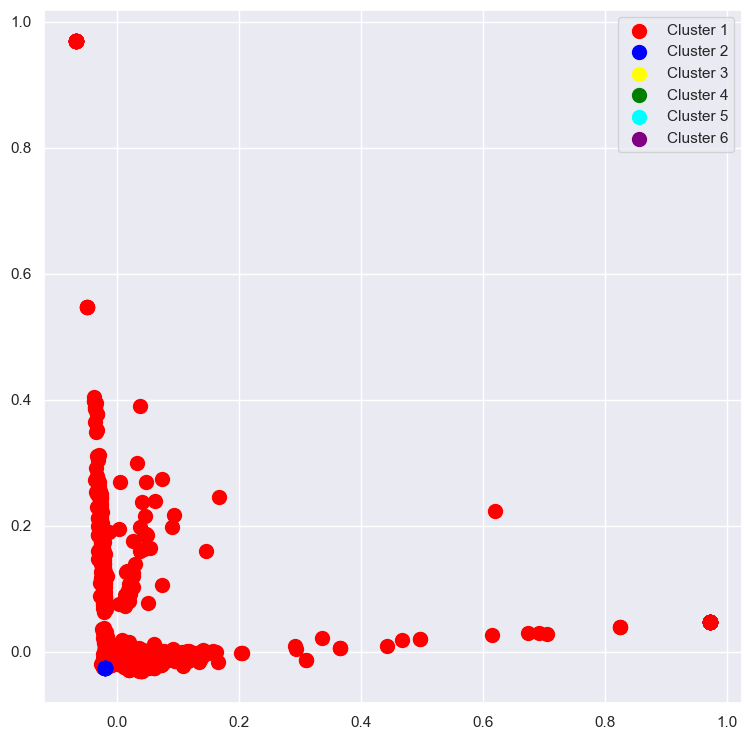

In [75]:
plt.figure(figsize =(9, 9))
plt.scatter(pca_X[label == 0, 0], pca_X[label == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(pca_X[label == 1, 0], pca_X[label == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(pca_X[label == 2, 0], pca_X[label == 2, 1], s = 100, c = 'yellow', label = 'Cluster 3')
plt.scatter(pca_X[label == 3, 0], pca_X[label == 3, 1], s = 100, c = 'green', label = 'Cluster 4')
plt.scatter(pca_X[label == 4, 0], pca_X[label == 4, 1], s = 100, c = 'cyan', label = 'Cluster 5')
plt.scatter(pca_X[label == 5, 0], pca_X[label == 5, 1], s = 100, c = 'purple', label = 'Cluster 6')
  
# Building the legend
plt.legend()
plt.show()